# Laporan Proyek Machine Learning - Submission 2: System Recommender
- Nama: Imam Agus Faisal
- Email: imamagusfaisal120@gmail.com
- Id Dicoding: imamaf

## Problem Statement

- Bagaimana cara membuat rekomendasi film yang mempunyai karakteristik hampir sama dengan film yang pernah dilihat?
- Bagaimana cara merekomendasikan film berdasarkan preferensi pengguna?

## Menyiapkan semua library yang dibutuhkan

In [56]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

## Data Wrangling

**Memuat setiap tabel pada dataset**

In [57]:
movies_df=pd.read_csv("datasets/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [58]:
ratings_df=pd.read_csv("datasets/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Assessing Data
**Melihat informasi, Memeriksa missing value, Memeriksa duplikasi, dan Memeriksa parameter statistik pada setiap tabel**

In [59]:
print('\n', movies_df.info())
print('\nMissing value movies:\n', movies_df.isnull().sum())
print('\nJumlah duplikasi movies:\n', movies_df.duplicated().sum())
print('\n\nParameter statistik movies:\n', movies_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

 None

Missing value movies:
 movieId    0
title      0
genres     0
dtype: int64

Jumlah duplikasi movies:
 0


Parameter statistik movies:
              movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000


In [60]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [61]:
print('\n', ratings_df.info())
print('\nMissing value ratings:\n', ratings_df.isnull().sum())
print('\nJumlah duplikasi ratings:\n', ratings_df.duplicated().sum())
print('\n\nParameter statistik ratings:\n', ratings_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

 None

Missing value ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Jumlah duplikasi ratings:
 0


Parameter statistik ratings:
               userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000  

In [62]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Rangkuman Hasil Analisis Tahap Assesing Data pada Dataset:**
*   Tidak terdapat missing value
*   Tidak terdapat adanya duplikasi
*   Terdapat innacurate type value pada kolom timestamp
*   Terdapat tahun movie diproduksi yang dapat dipindahkan ke dalam kolom tersendiri



### Cleaning Data
Memisahkan tahun produksi movie kedalam kolom tersendiri

In [63]:
#Using regular expressions to find a year stored between parentheses

#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract(r'\((\d{4})\)')

#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace(r'\((\d{4})\)', '')

#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

Mengubah timestamp bertipe int64 menjadi datetime

In [64]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

Mengecek kembali dataset yang sudah dibersihkan

In [65]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [66]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


## Exploratory Data Analysis (EDA)

### Univariate Analysis

Jumlah movie yang dirilis setiap tahun

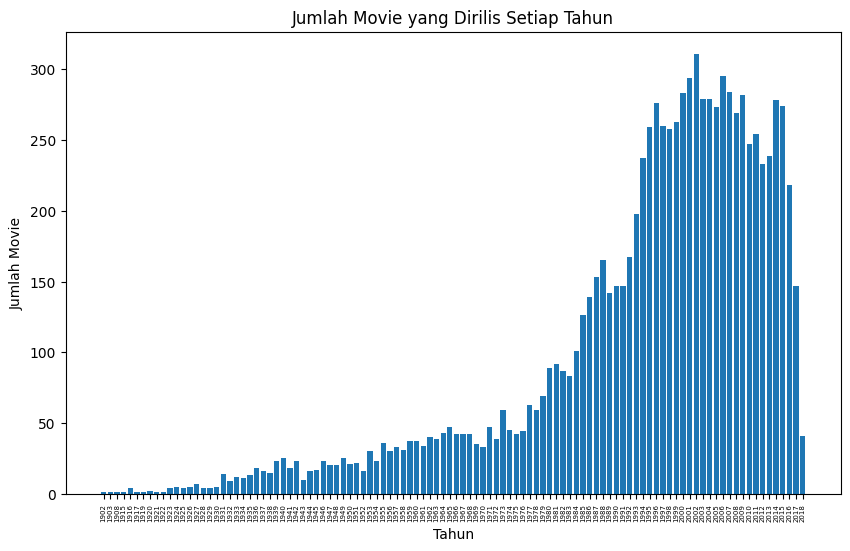

In [67]:
# Group movies by year and count the number of movies
movie_counts = movies_df['year'].value_counts().sort_index()

# Plotting the number of movies released each year
plt.figure(figsize=(10, 6))
plt.bar(movie_counts.index, movie_counts.values)
plt.xlabel('Tahun')
plt.xticks(fontsize=5, rotation=90)
plt.ylabel('Jumlah Movie')
plt.title('Jumlah Movie yang Dirilis Setiap Tahun')
plt.show()

Jumlah rating yang diberikan setiap tahun

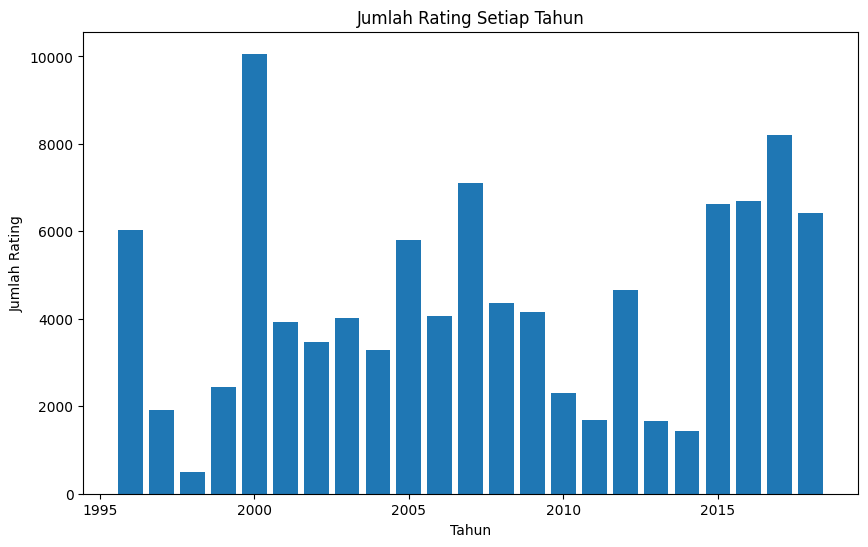

In [68]:
rating_counts = ratings_df['timestamp'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Tahun')
plt.ylabel('Jumlah Rating')
plt.title('Jumlah Rating Setiap Tahun')
plt.show()

### Multivariate Analysis

Gabungkan dataset movie dengan datset rating

In [14]:
merged_df = movies_df.merge(ratings_df, on='movieId')

Top 10 Movie dengan jumlah rating terbanyak

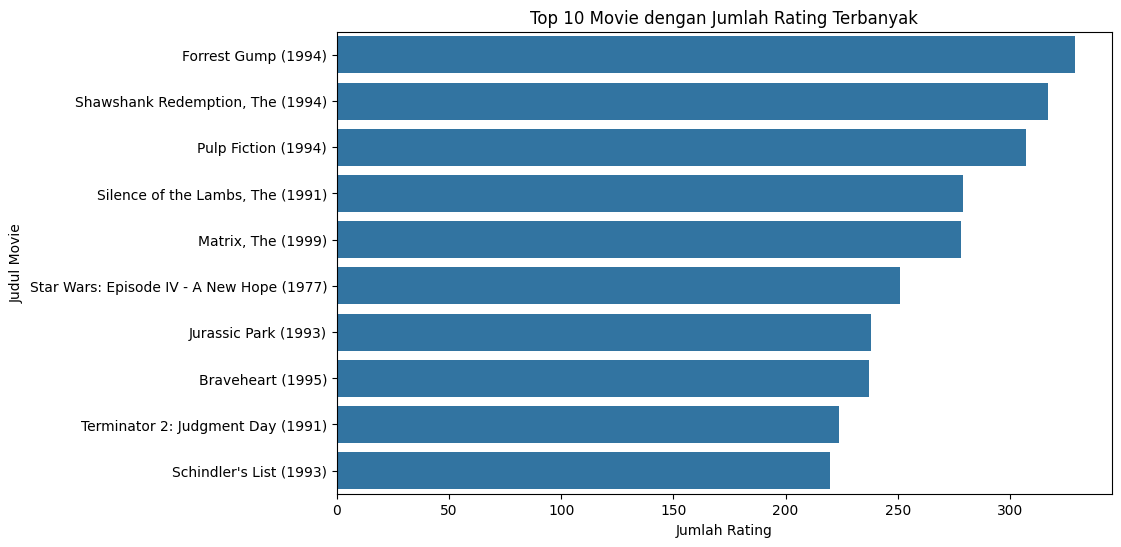

In [15]:
# Count the number of ratings for each movie
movie_ratings = merged_df['title'].value_counts().head(10)

# Plotting the top 10 most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x=movie_ratings.values, y=movie_ratings.index)
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Movie')
plt.title('Top 10 Movie dengan Jumlah Rating Terbanyak')
plt.show()

Top 10 Movie dengan jumlah rating paling sedikit

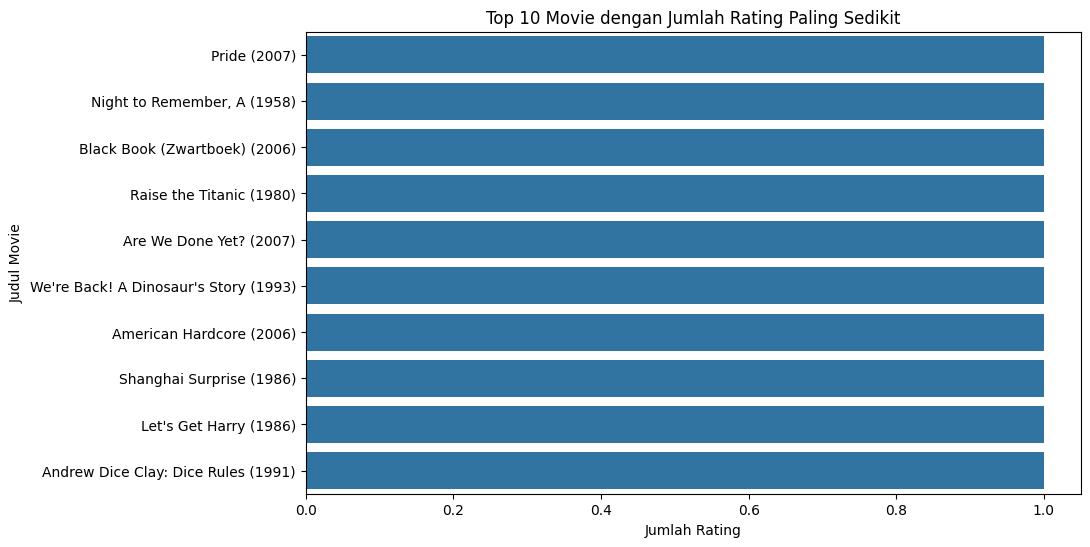

In [16]:
# Count the number of ratings for each movie
movie_ratings = merged_df['title'].value_counts().tail(10)

# Plotting the top 10 most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x=movie_ratings.values, y=movie_ratings.index)
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Movie')
plt.title('Top 10 Movie dengan Jumlah Rating Paling Sedikit')
plt.show()

Distribusi Rating pada Semua Movie

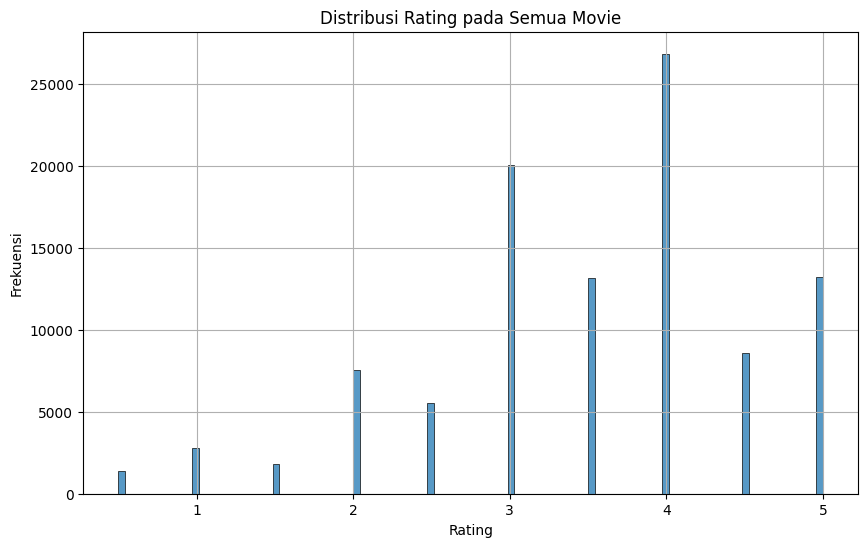

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'])
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.title('Distribusi Rating pada Semua Movie')
plt.grid()
plt.show()

Distribusi Rating pada Movie Tertentu

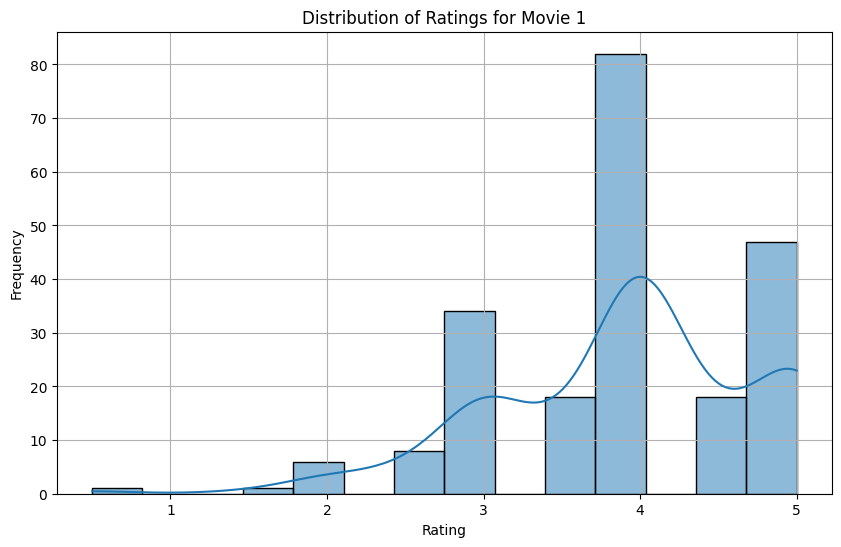

In [18]:
movie_id = 1  # Specify the movie ID for analysis

# Filter ratings data for the specific movie
movie_ratings = ratings_df[ratings_df['movieId'] == movie_id]['rating']

# Plotting the distribution of ratings for the specific movie
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings, kde=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title(f'Distribution of Ratings for Movie {movie_id}')
plt.grid()
plt.show()

Rata-rata Rating Setiap Tahun

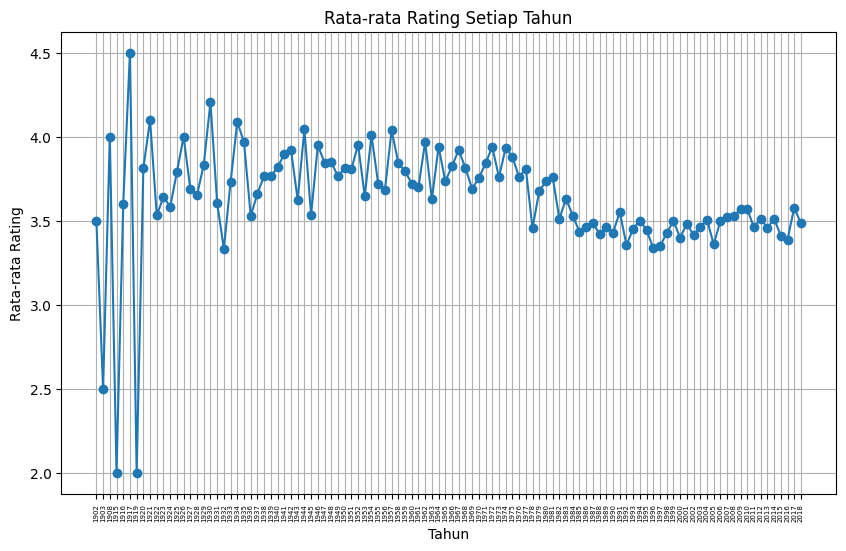

In [19]:
# Calculate the average rating for each year
avg_ratings = merged_df.groupby('year')['rating'].mean()

# Plotting the average rating for each year
plt.figure(figsize=(10, 6))
plt.plot(avg_ratings.index, avg_ratings.values, marker='o')
plt.xlabel('Tahun')
plt.xticks(fontsize=5, rotation=90)
plt.ylabel('Rata-rata Rating')
plt.title('Rata-rata Rating Setiap Tahun')
plt.grid()
plt.show()

Rata-rata Rating Setiap Movie

In [20]:
# Average rating for each movie genre
average_rating_movie = merged_df.groupby('movieId')['rating'].mean()

print(average_rating_movie)

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64


## Data Preparation

### Data Preparation untuk Content Based Filtering

Mengurutkan movie berdasarkan Id

In [21]:
prep_movies = merged_df.sort_values(by='movieId')

Mengecek jumlah unique movie berdasarkan Id

In [22]:
len(prep_movies.movieId.unique())

9724

Menghilangkan duplikat movieId

In [23]:
prep_movies = prep_movies.drop_duplicates('movieId')

Mengkonversi data menjadi list

In [24]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = prep_movies['movieId'].tolist()
 
# Mengonversi data series ‘title’ menjadi dalam bentuk list
movie_name = prep_movies['title'].tolist()
 
# Mengonversi data series ‘genres’ menjadi dalam bentuk list
movie_genre = prep_movies['genres'].tolist()

Mengecek panjang kolom

In [25]:
print(len(movie_id))
print(len(movie_name))
print(len(movie_genre))

9724
9724
9724


Membuat dictionary untuk menentukan pasangan Key-Value

In [26]:
movie_dict = pd.DataFrame({
    'id':movie_id,
    'movie_name':movie_name,
    'genre':movie_genre
})
movie_dict

,id,movie_name,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9721,193585,Flint (2017),Drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### Data Preparation untuk Collaborative Filtering

Membuat dataframe untuk collaborative filtering

In [27]:
collaborative_df = ratings_df

Encoding userId dan MovieId ke dalam indeks integer

In [28]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = collaborative_df['userId'].unique().tolist()
print('list userID: ', user_ids)
 
# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [29]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = collaborative_df['movieId'].unique().tolist()
print('list movieId: ', movie_ids)
 
# Melakukan encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('encoded movieId : ', movie_to_movie_encoded)
 
# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke movieId: ', movie_encoded_to_movie)

list movieId:  [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 457, 480, 500, 527, 543, 552, 553, 590, 592, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1222, 1224, 1226, 1240, 1256, 1258, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1377, 1396, 1408, 1445, 1473, 1500, 1517, 1552, 1573, 1580, 1587, 1617, 1620, 1625, 1644, 1676, 1732, 1777, 1793, 1804, 1805, 1920, 1927, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2253, 2268, 2273, 2291, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2640, 2641

Memetakan userId dan MovieId ke dalam dataframe

In [30]:
# Mapping userId ke dataframe user
collaborative_df['user'] = collaborative_df['userId'].map(user_to_user_encoded)
 
# Mapping movieId ke dataframe movie
collaborative_df['movie'] = collaborative_df['movieId'].map(movie_to_movie_encoded)

Mengecek jumlah data user dan movie

In [31]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
 
# Mendapatkan jumlah movie
num_movie = len(movie_encoded_to_movie)
 
# Nilai minimum rating
min_rating = min(collaborative_df['rating'])
 
# Nilai maksimal rating
max_rating = max(collaborative_df['rating'])
 
print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


##### Membagi data untuk Training dan Validasi

Mengacak data

In [32]:
collaborative_df = collaborative_df.sample(frac=1, random_state=42)
collaborative_df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,2012-04-23 00:07:21,431,4730
42175,288,474,3.0,2001-01-02 19:59:25,287,474
93850,599,4351,3.0,2017-06-27 00:49:02,598,2631
6187,42,2987,4.0,2001-07-27 19:37:57,41,194
12229,75,1610,4.0,2006-09-23 05:37:21,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,2001-07-27 18:37:39,41,1873
54886,364,141,4.0,1997-07-21 00:02:47,363,524
76820,480,6867,4.0,2007-05-14 17:19:31,479,2240
860,6,981,3.0,1996-10-17 12:49:27,5,712


Memetakan data user dan movie, lalu membagi data training dan validasi dengan rasio 80:20

In [33]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = collaborative_df[['user', 'movie']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = collaborative_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * collaborative_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


## Model Development

### Content Based Filtering

TF-IDF Vectorizer

In [34]:
# Inisialisasi TfidfVectorizer
tfid = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data genre
tfid.fit(movie_dict['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tfid.get_feature_names_out() 

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

Melakukan Fit dan Transformasikan ke bentuk Matrik

In [35]:
tfidf_matrix = tfid.fit_transform(movie_dict['genre']) 
tfidf_matrix.todense()

matrix([[0.        , 0.41681721, 0.51634045, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51235785, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57836121, 0.        , 0.8157808 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Menghitung kesamaan dengan **Cosine Similarity**

In [36]:
movie_cosine = cosine_similarity(tfidf_matrix)
movie_cosine

array([[1.        , 0.81352752, 0.15262722, ..., 0.        , 0.42122062,
        0.26751731],
       [0.81352752, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15262722, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57053212],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42122062, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26751731, 0.        , 0.57053212, ..., 0.        , 0.        ,
        1.        ]])

Membuat dataframe dari hasil Cosine Similarity

In [37]:
movie_cosine_df = pd.DataFrame(movie_cosine, index=movie_dict['movie_name'], columns=movie_dict['movie_name'])
print('Shape:', movie_cosine_df.shape)
 
movie_cosine_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9724, 9724)


movie_name,Mirror Mirror (2012),Message in a Bottle (1999),Howards End (1992),Masquerade (1988),Meatballs Part II (1984)
movie_name,,,,,
Wizards of the Lost Kingdom II (1989),0.556470,0.000000,0.000000,0.000000,0.000000
DiG! (2004),0.000000,0.000000,0.000000,0.000000,0.000000
Airport (1970),0.000000,0.000000,1.000000,0.000000,0.000000
Mystic Pizza (1988),0.195131,0.726418,0.466539,0.375645,0.504636
Dragonheart 2: A New Beginning (2000),0.771308,0.000000,0.275732,0.195724,0.298247
Gulliver's Travels (1939),0.301207,0.000000,0.000000,0.000000,0.000000
"Real Blonde, The (1997)",0.386677,0.000000,0.000000,0.000000,1.000000
Rambo: First Blood Part II (1985),0.379241,0.000000,0.000000,0.265122,0.000000
All Roads Lead to Rome (2016),0.386677,0.000000,0.000000,0.000000,1.000000


membuat fungsi movie_recommendations dengan beberapa parameter sebagai berikut:
- movie_name : Nama judul dari movie tersebut (index kemiripan dataframe).
- similarity_data : Dataframe mengenai similarity yang telah kita didefinisikan sebelumnya
- items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘movie_name’ dan ‘genre’.
- k : Banyak rekomendasi yang ingin diberikan.

In [38]:
def movie_recommendations(movie_name, similarity=movie_cosine_df, items=movie_dict[['movie_name', 'genre']], k=5):
   
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity.loc[:,movie_name].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity.columns[index[-1:-(k+2):-1]]
    
    # Drop movie_name agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(movie_name, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

Mengecek fungsi movie_recommendations dan melihat hasilnya

In [39]:
movie_input = 'Toy Story (1995)'
print('Detail genre movie:\n\n', movie_dict[movie_dict.movie_name.eq(movie_input)])
print('\n\nResult top 5 movie recommendation:')
movie_recommendations(movie_input)

Detail genre movie:

    id        movie_name                                        genre
0   1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy


Result top 5 movie recommendation:


,movie_name,genre
0,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
1,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
3,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
4,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy


### Collaborative Filtering

Membuat kelas RecommenderNet untuk Collaborative Filtering

In [40]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movies
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movies bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

Mengcompile model

In [41]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

2023-10-14 22:01:28.739468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-14 22:01:28.829652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-14 22:01:28.831141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Melakukan training model

In [42]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 25,
    validation_data = (x_val, y_val)
)

Epoch 1/25


2023-10-14 22:01:33.423760: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f77b940d0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-14 22:01:33.424006: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2023-10-14 22:01:33.437174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-14 22:01:33.476896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-14 22:01:33.738289: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-14 22:01:33.913677: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2521/2521 [==============================] - 22s 7ms/step - loss: 0.6345 - root_mean_squared_error: 0.2305 - val_loss: 0.6179 - val_root_mean_squared_error: 0.2120
Epoch 2/25
2521/2521 [==============================] - 11s 4ms/step - loss: 0.6112 - root_mean_squared_error: 0.2058 - val_loss: 0.6131 - val_root_mean_squared_error: 0.2067
Epoch 3/25
2521/2521 [==============================] - 11s 4ms/step - loss: 0.6063 - root_mean_squared_error: 0.2003 - val_loss: 0.6103 - val_root_mean_squared_error: 0.2035
Epoch 4/25
2521/2521 [==============================] - 26s 10ms/step - loss: 0.6039 - root_mean_squared_error: 0.1975 - val_loss: 0.6103 - val_root_mean_squared_error: 0.2035
Epoch 5/25
2521/2521 [==============================] - 53s 21ms/step - loss: 0.6026 - root_mean_squared_error: 0.1958 - val_loss: 0.6099 - val_root_mean_squared_error: 0.2029
Epoch 6/25
2521/2521 [==============================] - 46s 18ms/step - loss: 0.6017 - root_mean_squared_error: 0.1946 - val_loss: 0.6

## Evaluasi Model

Visualisasi metrik

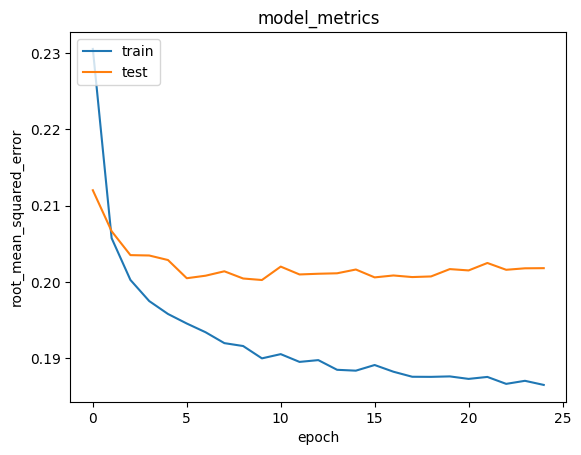

In [43]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Mendapatkan Rekomendasi Movie

In [44]:
movie_df = movie_dict
df = pd.read_csv('datasets/ratings.csv')
 
# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_visited_by_user = df[df.userId == user_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
movie_not_visited = movie_df[~movie_df['id'].isin(movie_visited_by_user.movieId.values)]['id'] 
movie_not_visited = list(
    set(movie_not_visited)
    .intersection(set(movie_to_movie_encoded.keys()))
)
 
movie_not_visited = [[movie_to_movie_encoded.get(x)] for x in movie_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_visited), movie_not_visited)
)

Rekomendasi Movie untuk User

In [55]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)
 
top_movie_user = (
    movie_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_name, ':', row.genre)
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_name, ':', row.genre)

274/274 [==============================] - 4s 14ms/step
Showing recommendations for users: 307
Movie with high ratings from user
--------------------------------
American History X (1998) : Crime|Drama
Eternal Sunshine of the Spotless Mind (2004) : Drama|Romance|Sci-Fi
Shaun of the Dead (2004) : Comedy|Horror
Reign Over Me (2007) : Drama
Hangover, The (2009) : Comedy|Crime
--------------------------------
Top 10 movie recommendation
--------------------------------
Underground (1995) : Comedy|Drama|War
Streetcar Named Desire, A (1951) : Drama
Cinema Paradiso (Nuovo cinema Paradiso) (1989) : Drama
Paths of Glory (1957) : Drama|War
Touch of Evil (1958) : Crime|Film-Noir|Thriller
Night on Earth (1991) : Comedy|Drama
Double Indemnity (1944) : Crime|Drama|Film-Noir
Trial, The (Procès, Le) (1962) : Drama
Day of the Doctor, The (2013) : Adventure|Drama|Sci-Fi
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
